In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings
import seaborn as sns

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 40)
warnings.filterwarnings("ignore")

In [2]:
df_item_categories = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')
df_sales_train = pd.read_csv('sales_train.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')
df_shops = pd.read_csv('shops.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_test.item_id.unique()

array([ 5037,  5320,  5233, ..., 15757, 19648,   969])

In [4]:
df_item_categories.head()

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [5]:
df_test.item_id.nunique()

5100

In [6]:
df_test.shop_id.nunique()

42

In [7]:
df_test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [8]:
df_sales_train.item_id.nunique()

21807

In [9]:
df_sales_train.shop_id.nunique()

60

In [10]:
train_item = df_sales_train.item_id.unique()

In [11]:
train_shop = df_sales_train.shop_id.unique()

In [12]:
test_item = df_test.item_id.unique()

In [13]:
test_shop = df_test.shop_id.unique()

In [14]:
it=set(test_item)
itr = set(train_item)
st = set(test_shop)

In [15]:
item_diff = [x for x in train_item if x not in it]

In [16]:
len(item_diff)

17070

In [17]:
shop_diff = set([x for x in train_shop if x not in st])

In [18]:
len(shop_diff)

18

In [19]:
df_sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


preparing training df

In [20]:
df_sales_train['date'] = pd.to_datetime(df_sales_train.date,format='%d.%m.%Y')
df_sales_train['revenue'] = df_sales_train.item_price * df_sales_train.item_cnt_day
df_sales_train['year'] = df_sales_train['date'].dt.year
df_sales_train['month'] = df_sales_train['date'].dt.month
df_sales_train['day'] = df_sales_train['date'].dt.day

In [21]:
df_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   revenue         float64       
 7   year            int64         
 8   month           int64         
 9   day             int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 224.0 MB


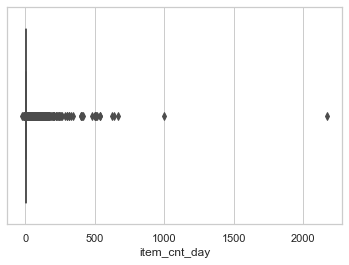

In [22]:
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.boxplot(x=df_sales_train.item_cnt_day)

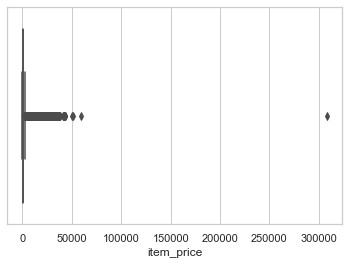

In [23]:
bx = sns.boxplot(x=df_sales_train.item_price)

In [24]:
dfa = df_sales_train[(df_sales_train.item_price < 100000) & (df_sales_train.item_price > 0)]
dfa = dfa[dfa.item_cnt_day < 1001]

In [25]:
df4 = dfa.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','revenue':'sum'})

In [26]:
df5 = df4.reset_index()

In [27]:
dft = df_test.copy()
dft['date_block_num'] = 34
dft['year'] = 2015
dft['month'] = 11
# dft['year'] = dft['year'].astype('float64')
# dft['month'] = dft['month'].astype('int8')
# dft['date_block_num'] = dft['date_block_num'].astype('int8')
# dft['shop_id'] = dft['shop_id'].astype('float64')
# dft['item_id'] = dft['item_id'].astype('float64')
df6 = pd.concat([df5,dft], ignore_index=True)

In [28]:
df6.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace = True)

In [29]:
def lag(df,lag,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lag:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col + '_lag_' + str(i)]
        shifted['date_block_num'] +=i
        df = pd.merge(df,shifted, on=['date_block_num','shop_id','item_id'], how = 'left')
        df[col+'_lag_'+ str(i)] = df[col+'_lag_'+ str(i)].astype('float16')
    return df

In [30]:
df7= lag(df6,[1,2,3],'item_cnt_month')

In [31]:
df7

,date_block_num,shop_id,item_id,item_cnt_month,revenue,ID,year,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,1326.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,1041.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,247.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,221.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,257.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1823318,34,45,18454,NaN,NaN,214195.0,2015.0,11.0,1.0,NaN,NaN
1823319,34,45,16188,NaN,NaN,214196.0,2015.0,11.0,NaN,NaN,NaN
1823320,34,45,15757,NaN,NaN,214197.0,2015.0,11.0,NaN,NaN,NaN
1823321,34,45,19648,NaN,NaN,214198.0,2015.0,11.0,NaN,NaN,NaN


In [32]:
df7.fillna(0, inplace = True)

In [33]:
df_testf = df7[df7.date_block_num == 34]
df_trainf = df7[df7.date_block_num<34]

In [34]:
df_trainf

,date_block_num,shop_id,item_id,item_cnt_month,revenue,ID,year,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,1326.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,33,3.0,1041.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,51,2.0,257.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1609118,33,59,22087,6.0,714.0,0.0,0.0,0.0,3.0,2.0,5.0
1609119,33,59,22088,2.0,238.0,0.0,0.0,0.0,1.0,7.0,7.0
1609120,33,59,22091,1.0,179.0,0.0,0.0,0.0,3.0,0.0,0.0
1609121,33,59,22100,1.0,629.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
df_testf

,date_block_num,shop_id,item_id,item_cnt_month,revenue,ID,year,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
1609123,34,5,5037,0.0,0.0,0.0,2015.0,11.0,0.0,1.0,3.0
1609124,34,5,5320,0.0,0.0,1.0,2015.0,11.0,0.0,0.0,0.0
1609125,34,5,5233,0.0,0.0,2.0,2015.0,11.0,1.0,3.0,1.0
1609126,34,5,5232,0.0,0.0,3.0,2015.0,11.0,0.0,0.0,1.0
1609127,34,5,5268,0.0,0.0,4.0,2015.0,11.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1823318,34,45,18454,0.0,0.0,214195.0,2015.0,11.0,1.0,0.0,0.0
1823319,34,45,16188,0.0,0.0,214196.0,2015.0,11.0,0.0,0.0,0.0
1823320,34,45,15757,0.0,0.0,214197.0,2015.0,11.0,0.0,0.0,0.0
1823321,34,45,19648,0.0,0.0,214198.0,2015.0,11.0,0.0,0.0,0.0


In [36]:
df_trainf.drop(['ID','year','month','revenue'],axis = 1, inplace = True)
df_testf.drop(['ID','year','month','revenue'],axis = 1, inplace = True)

In [37]:
df_trainf = df_trainf[df_trainf.date_block_num > 2]

In [38]:
X_train = df_trainf[df_trainf.date_block_num < 33].drop(['item_cnt_month'], axis =1)
y_train = df_trainf[(df_trainf.date_block_num < 33)]['item_cnt_month']

In [39]:
X_valid = df_trainf[df_trainf.date_block_num == 33].drop(['item_cnt_month'], axis =1)
y_valid = df_trainf[(df_trainf.date_block_num == 33)]['item_cnt_month']
X_test = df_testf

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

model_params = {
    'svm' : {
        'model' : SVC(gamma ='auto'),
        'params' : {
            'C' : [1,10,20],
            'kernel' : ['linear','rbf']
        }
    },
    'Random_Forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : [5,10,40]
        }
    },
    
    'Gaussian_NB' : {
        'model' : GaussianNB(),
        'params' : {}
    },
    'Multinomial_NB' : {
        'model' : MultinomialNB(),
        'params' : {}
    },
#     'linear_regression' : {
#             'model': LinearRegression(),
#             'params': {
#                 'normalize': [True, False]
#             }
#         },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
    'Decisicion_Trees' : {
        'model' : DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini','entropy']
        }
    }
}

score= []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'], return_train_score=False)
    clf.fit(X_train,y_train)
    score.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_,
    })
final_bhp = pd.DataFrame(score, columns = ['model', 'best_score','best_params'])
final_bhp